In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('D:/Final qualifying work/main') 
sys.path.append('D:/Final qualifying work/main/source') 

from source.core import Camera
from source.calibration import VanishingPointEstimator, VanishingPointCalibration

%matplotlib inline

In [2]:
def load_lines(filename):
    _filename = os.path.join("vp", filename)
    if not os.path.exists(_filename):
        print("Файл аннотаций не найден.")
        return

    with open(_filename, "r") as f:
        data = json.load(f)

    # Преобразуем строки ключей обратно в список линий
    lines = [[tuple(point) for point in line] for line in data.values()]
    return lines

In [3]:
def draw_coordinate_axes_from_vps(vanishing_points, center, scale=100, labels=None, colors=None, flip_z=True):
    """
    Рисует координатные оси X, Y, Z от центра изображения по направлению к точкам схода.

    :param vanishing_points: список [(x1, y1), (x2, y2), (x3, y3)] — координаты VP
    :param center: (cx, cy) — центр изображения (или центр проекции камеры)
    :param scale: длина стрелок (в пикселях)
    :param labels: подписи осей, по умолчанию ['X', 'Y', 'Z']
    :param colors: цвета осей, по умолчанию ['red', 'green', 'blue']
    """
    if labels is None:
        labels = ['X', 'Y', 'Z']
    if colors is None:
        colors = ['red', 'green', 'blue']

    cx, cy = center

    for i, (x, y) in enumerate(vanishing_points):
        dx = x - cx
        dy = y - cy
        norm = np.hypot(dx, dy)
        dx_scaled = dx / norm * scale
        dy_scaled = dy / norm * scale

        # if flip_z and labels[i].upper() == 'Y':
        #     dx_scaled *= -1
        #     dy_scaled *= -1

        # Рисуем стрелку оси
        plt.arrow(cx, cy, dx_scaled, dy_scaled,
                  color=colors[i], width=1.2, head_width=10, length_includes_head=True)


In [4]:
lines_vp1 = load_lines("vp1.json")
lines_vp2 = load_lines("vp2.json")
lines_vp3 = load_lines("vp3.json")

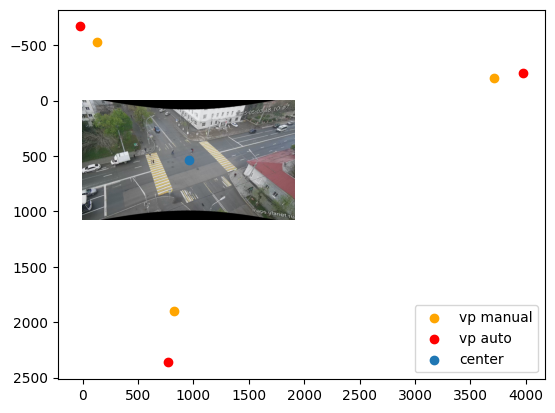

In [5]:
image = cv2.imread('image/pattern_corrected_image.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

vp1_manual = VanishingPointEstimator().estimate(lines_vp1)
vp2_manual = VanishingPointEstimator().estimate(lines_vp2)
vp3_manual = VanishingPointEstimator().estimate(lines_vp3)

vps_manual = np.array([vp1_manual, vp3_manual,vp2_manual])

plt.scatter(vps_manual[:,0],vps_manual[:,1], label='vp manual', c='orange')

vp1 = [3974.185, -248.69977]
vp2 = [768.4042, 2362.912]
vp3 = [-24.940735, -669.0249]

vps_auto = np.array([vp1,vp2, vp3])
plt.scatter(vps_auto[:,0],vps_auto[:,1], label='vp auto', c='red')

plt.scatter(960,540, label = 'center')

plt.legend()


# Ручная разметка

In [6]:
camera = Camera('image/pattern_corrected_image.png')
calibrationVP = VanishingPointCalibration(camera)
calibrationVP.set_vanishing_points(*vps_manual)
f = calibrationVP.calc_f()
print(f'Фокусное расстояние: {f}')
R = np.array(calibrationVP.calc_R(f))
print(f'Rot:\n{R}')

Фокусное расстояние: 1179.0746221290515
Rot:
[[ 0.89223005 -0.44636264  0.0684538 ]
 [-0.2410857  -0.59900726 -0.76358888]
 [ 0.38184188  0.66479372 -0.64206393]]


In [7]:
print("Ортонормальность:")
print("r1·r2 =", np.dot(R[:, 0], R[:, 1]))
print("r1·r3 =", np.dot(R[:, 0], R[:, 2]))
print("r2·r3 =", np.dot(R[:, 1], R[:, 2]))

print("det(R) =", np.linalg.det(R))

Ортонормальность:
r1·r2 = 9.818858443085795e-18
r1·r3 = -2.5037604244158657e-17
r2·r3 = 6.303756414389777e-17
det(R) = 0.9999999999999997


# С известным фокусным расстоянием через lu_vp_detect

In [9]:
calibrationVP.set_vanishing_points(vps_manual[0],vpZ=vps_manual[2])
f = calibrationVP.calc_f()
print(f'Фокусное расстояние: {f}')
R = np.array(calibrationVP.calc_R(f))
print(f'Rot:\n{R}')

Фокусное расстояние: 1179.0746221290515
Rot:
[[ 0.89223005 -0.44636264  0.0684538 ]
 [-0.2410857  -0.59900726 -0.76358888]
 [ 0.38184188  0.66479372 -0.64206393]]


In [10]:
print("Ортонормальность:")
print("r1·r2 =", np.dot(R[:, 0], R[:, 1]))
print("r1·r3 =", np.dot(R[:, 0], R[:, 2]))
print("r2·r3 =", np.dot(R[:, 1], R[:, 2]))

print("det(R) =", np.linalg.det(R))

Ортонормальность:
r1·r2 = 9.818858443085795e-18
r1·r3 = -2.5037604244158657e-17
r2·r3 = 6.303756414389777e-17
det(R) = 0.9999999999999997


In [11]:
dp3 = np.cross(R[:,0],R[:,1])
print(dp3)
dp3 / np.linalg.norm(dp3)

[ 0.0684538  -0.76358888 -0.64206393]


array([ 0.0684538 , -0.76358888, -0.64206393])

# Ориентация камеры через точки схода

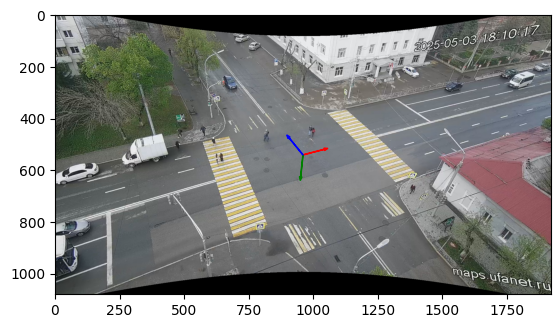

In [12]:
center = (960,540)
plt.imshow(image_rgb)
draw_coordinate_axes_from_vps(vps_auto,center)

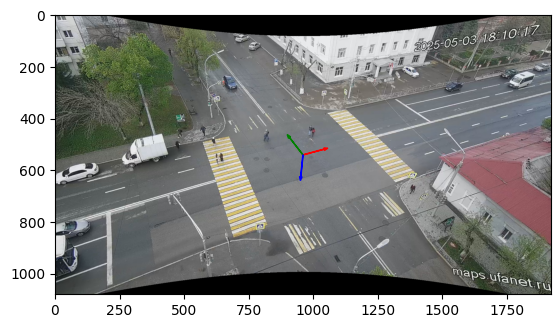

In [13]:
center = (960,540)
plt.imshow(image_rgb)
draw_coordinate_axes_from_vps(vps_manual,center)

# Иной подход

In [14]:
K = camera.intrinsics.get()
print(f'Внутренние параметры камеры:\n{K}')

Внутренние параметры камеры:
[[1.17907462e+03 0.00000000e+00 9.60000000e+02]
 [0.00000000e+00 1.17907462e+03 5.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [15]:
VP = []
for i in range(3):
    vp = K @ R[:, i]
    vp = vp[:2]/vp[-1]
    VP.append(vp)
VP = np.array(VP)
print(f'VP:\n{VP}')

VP:
[[3715.08234813 -204.43911901]
 [ 168.33357524 -522.39611503]
 [ 834.29267857 1942.24084896]]


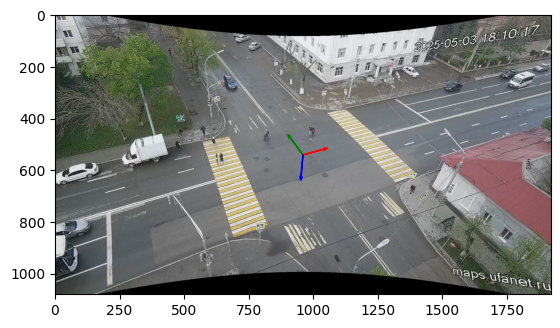

In [16]:
center = (960,540)
plt.imshow(image_rgb)
draw_coordinate_axes_from_vps(VP,center)